# PyTorch 60 minute blitz

## Tensors
See [Pytorch learning the basics](PyTorch Learn the Basics.ipynb#Tensors)

## AutoGrad 
See [Pytorch learning the basics](PyTorch Learn the Basics.ipynb### Automatic differentiation with `torch.autograd`)


## Neural Networks
Examin the example network below for classifying digit images:
![convnet](https://pytorch.org/tutorials/_images/mnist.png "ConvNet")

The typical training procedure is as follows:
1. Define the NN
2. Iterate over the dataset
3. Process the input through the NN
4. Compute the loss
5. Propagate the gradients
6. Update the weights

## Define the network:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # affine operation: y=wx+b
        self.fc1 = nn.Linear(16*5*5, 120)  # 5x5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2,2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify the max_pool with one number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # Flatten all dimension except the batch dimension
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  # returning logits

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [2]:
# The learnable parameters of the model.
params = list(net.parameters())
print(len(params))
print(params[0].size()) # conv1's .weight

10
torch.Size([6, 1, 5, 5])


`torch.nn` only supports mini-bathces, not snigle samples.

For eacmple `nn.Conv2d` takes a 4D Tensor of `nSamples x nChannels x Height x Width`.

If you only have one sample you can use `input.unsqueeze(0)` to add a fake batch dimension

In [3]:
# Random 32x32 input. Note: the expected input size of this network (LeNet) is 32x32. 
# To use this on MNIST you must resize the images.
input = torch.randn(1,32,32).unsqueeze(0)
out = net(input)
print(out)

tensor([[ 0.0577,  0.1085,  0.0341,  0.0014, -0.0224, -0.0445, -0.0360,  0.0211,
         -0.1071,  0.0507]], grad_fn=<AddmmBackward0>)


In [4]:
# zero out the gradient buffers with random gradients:
net.zero_grad()
out.backward(torch.randn(1,10))

## Computing the loss function, backprop and weight updates

In [5]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.8988, grad_fn=<MseLossBackward0>)


In [6]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0086, -0.0152,  0.0091,  0.0045,  0.0005, -0.0064])


In [7]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

## Training a Classifier
### What about data?
Can generally use standard python packages to load data into numpy arrays and convert these into Tensors.
- Images: Pillow, OpenCV
- Audio: SciPy and Librosa
- Text: Python, NLTK and SpaCy

Torchvision has dataloaders for common datasets such as ImageNet, CIFAR10, MNIST etc and data transformers for images.

We will use CIFAR10, the images are 3x32x32.

![CIGFAR10 examples](https://pytorch.org/tutorials/_images/cifar10.png)

### Training and image classifier
1. Load and normalize the CIFAR10 training and test datasets using `torchvision`.
2. Define a CNN
3. Define the loss function
4. Train the network on the training data
5. Test the network on the test data

#### 1. Load and normalize CIFAR10
The output of torchvision datasets are PILImage images in the [0,1] range, we want to normalize them to tensors in the [-1,1] range.

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


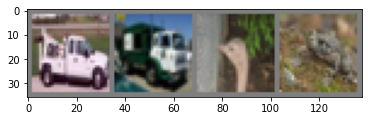

truck truck  bird  frog


In [10]:
# Visulise data
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# print("here")
# Get some random training images
dataiter = iter(trainloader)
# print("here")

images,labels = dataiter.next()
# print("here")

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

#### 2. Define the CNN
We're going to use the same network as before, except now it takes 3 channel images rather than 1 channel.

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

#### 3. Define loss and optimizer
Using Cross-Entropy loss  and SGD with momentum

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

#### 4. Train the NN

In [13]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs.cuda())
        loss = criterion(outputs.cpu(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.183
[1,  4000] loss: 1.818
[1,  6000] loss: 1.616
[1,  8000] loss: 1.551
[1, 10000] loss: 1.477
[1, 12000] loss: 1.450
[2,  2000] loss: 1.390
[2,  4000] loss: 1.363
[2,  6000] loss: 1.322
[2,  8000] loss: 1.318
[2, 10000] loss: 1.298
[2, 12000] loss: 1.256
Finished Training


In [14]:
# Save the model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#### 5. Test the network

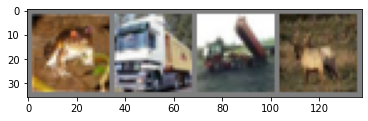

GroundTruth:   frog truck truck  deer


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# Print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
net = Net().cuda()
net.load_state_dict(torch.load(PATH))

outputs = net(images.cuda())
# Outputs are logits for 10 classes

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    dog truck truck  deer


In [17]:
from tqdm import tqdm

# test the entire test dataset
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

100%|██████████| 12500/12500 [00:18<00:00, 664.42it/s]

Accuracy of the network on the 10000 test images: 56 %


In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

from tqdm import tqdm

# again no gradients needed
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

100%|██████████| 12500/12500 [00:35<00:00, 351.41it/s]


Accuracy for class plane is: 63.1 %
Accuracy for class car   is: 71.9 %
Accuracy for class bird  is: 39.1 %
Accuracy for class cat   is: 54.7 %
Accuracy for class deer  is: 49.8 %
Accuracy for class dog   is: 49.5 %
Accuracy for class frog  is: 47.4 %
Accuracy for class horse is: 59.6 %
Accuracy for class ship  is: 57.1 %
Accuracy for class truck is: 74.6 %


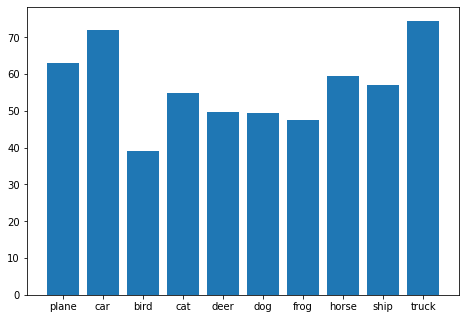

In [22]:
# print accuracy for each class
accuracies = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    accuracies.append(accuracy)
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(classes, accuracies)
plt.show()